In [42]:
import numpy as np 
import pandas as pd 
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

In [43]:
train_df = pd.read_csv('data/process/train_dataset_cleaned.csv')
test_df = pd.read_csv('data/process/test_dataset_cleaned.csv')
train_df.head()

,Image_name,Label,Processed_Text
0,train0001.jpg,Political,হরেক রকম চোর দিয়া বানাইছো মেলা পিসি তোমার দরবা...
1,train0002.jpg,NonPolitical,বর যাত্রী যাওয়ার টাইমে যখব গাড়িতে জায়গা কম পড়ে...
2,train0003.jpg,NonPolitical,তুমিকেখা নাবলল বুকে অনেক ব্যখাহেয় ঠিক মত পানি ...
3,train0004.jpg,NonPolitical,যখন ভল্লুক এসে পড়ে এবং আপন এবং আপনার রেস্টফরেন...
4,train0005.jpg,NonPolitical,বন্ধুযখন তার গফকেকাজিন বলে পরিচয় দেয় সম্পর্কবদ...


In [44]:
test_df.head()

,Image_name,Processed_Text
0,test0001.jpg,lose duck election comment ontheelection maid ...
1,test0002.jpg,matlablige fun
2,test0003.jpg,shlilisiiiiiieuiuriie
3,test0004.jpg,one absolutely one random এনসিপি বাগছাস নেতা g...
4,test0005.jpg,বন্ধু বিকাশের নতুন আপডেট দেখসস? অনেক নতুন ফিচা...


In [45]:
# Check available columns
print("Train DataFrame columns:")
print(train_df.columns.tolist())
print(f"\nShape: {train_df.shape}")
print("\nFirst few rows:")
print(train_df.head())

Train DataFrame columns:
['Image_name', 'Label', 'Processed_Text']

Shape: (2860, 3)

First few rows:
      Image_name         Label  \
0  train0001.jpg     Political   
1  train0002.jpg  NonPolitical   
2  train0003.jpg  NonPolitical   
3  train0004.jpg  NonPolitical   
4  train0005.jpg  NonPolitical   

                                      Processed_Text  
0  হরেক রকম চোর দিয়া বানাইছো মেলা পিসি তোমার দরবা...  
1  বর যাত্রী যাওয়ার টাইমে যখব গাড়িতে জায়গা কম পড়ে...  
2  তুমিকেখা নাবলল বুকে অনেক ব্যখাহেয় ঠিক মত পানি ...  
3  যখন ভল্লুক এসে পড়ে এবং আপন এবং আপনার রেস্টফরেন...  
4  বন্ধুযখন তার গফকেকাজিন বলে পরিচয় দেয় সম্পর্কবদ...  


# Text Cleaning and Analysis Pipeline

Professional text analysis for meme classification

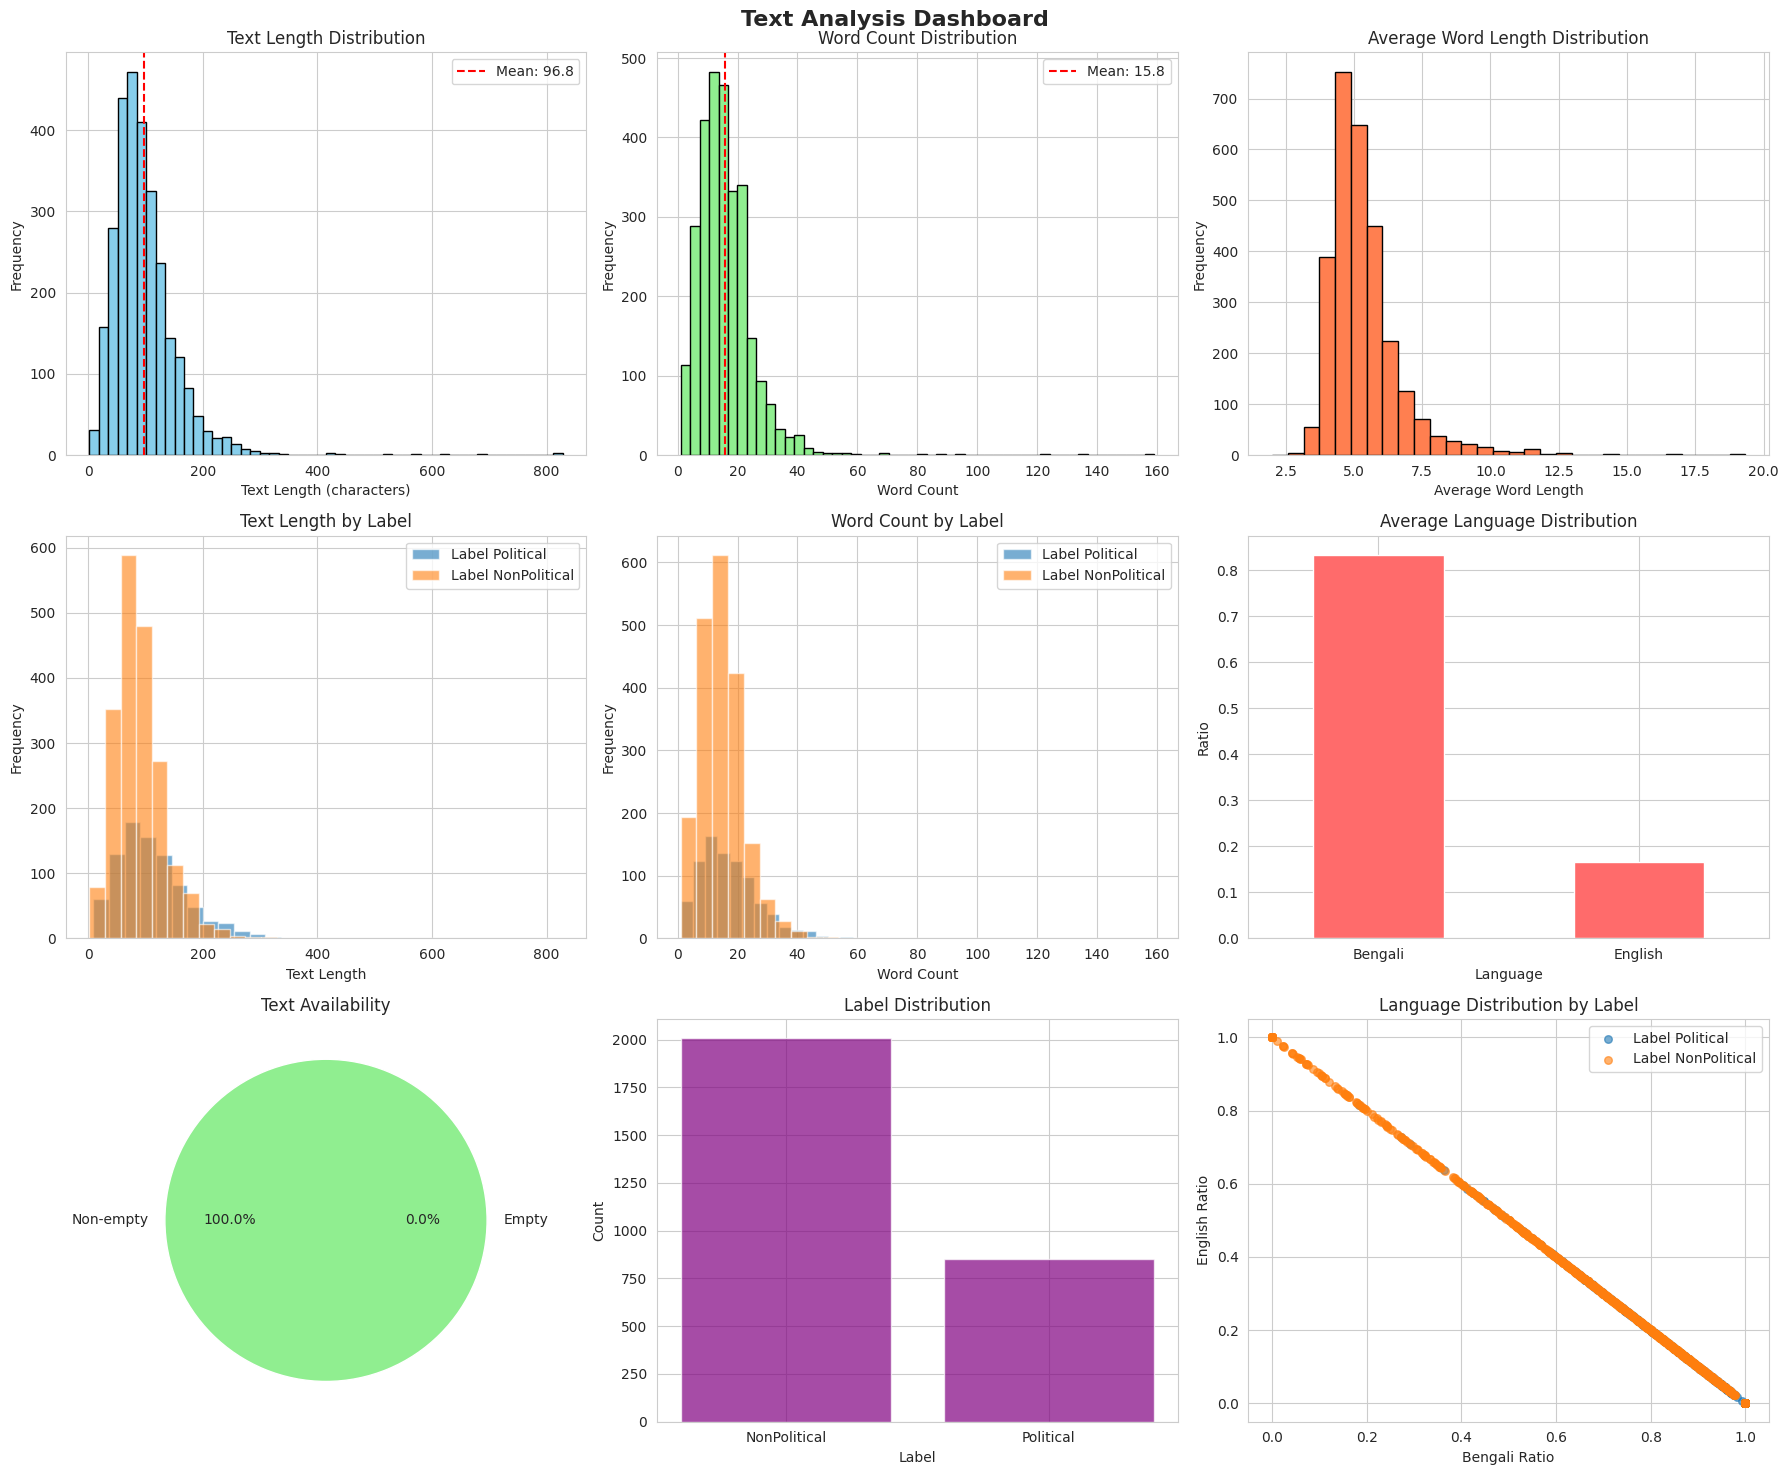


TEXT STATISTICS SUMMARY

Total samples: 2860
Empty texts: 0 (0.00%)
Non-empty texts: 2860 (100.00%)

Text Length Statistics:
  Mean: 96.75 characters
  Median: 86.00 characters
  Std: 56.70
  Min: 2
  Max: 828

Word Count Statistics:
  Mean: 15.77 words
  Median: 14.00 words
  Std: 9.37

Language Distribution:
  Average Bengali ratio: 83.31%
  Average English ratio: 16.69%

Statistics by Label:

  Label NonPolitical:
    Count: 2007
    Avg text length: 90.58
    Avg word count: 15.07
    Bengali ratio: 80.71%
    English ratio: 19.29%

  Label Political:
    Count: 853
    Avg text length: 111.28
    Avg word count: 17.41
    Bengali ratio: 89.42%
    English ratio: 10.58%


In [46]:
# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 8)

# Calculate text statistics
train_df['text_length'] = train_df['Processed_Text'].str.len()
train_df['word_count'] = train_df['Processed_Text'].str.split().str.len()
train_df['avg_word_length'] = train_df['Processed_Text'].apply(
    lambda x: np.mean([len(word) for word in str(x).split()]) if len(str(x).split()) > 0 else 0
)

# Detect language distribution (Bengali vs English)
def detect_language_ratio(text):
    if not text or text == '':
        return 0, 0, 0
    bengali_chars = len(re.findall(r'[\u0980-\u09FF]', text))
    english_chars = len(re.findall(r'[a-zA-Z]', text))
    total = bengali_chars + english_chars
    if total == 0:
        return 0, 0, 0
    return bengali_chars/total, english_chars/total, total

train_df[['bengali_ratio', 'english_ratio', 'char_count']] = train_df['Processed_Text'].apply(
    lambda x: pd.Series(detect_language_ratio(x))
)

# Create comprehensive analysis plots
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.suptitle('Text Analysis Dashboard', fontsize=16, fontweight='bold')

# 1. Text length distribution
axes[0, 0].hist(train_df['text_length'], bins=50, color='skyblue', edgecolor='black')
axes[0, 0].set_xlabel('Text Length (characters)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Text Length Distribution')
axes[0, 0].axvline(train_df['text_length'].mean(), color='red', linestyle='--', label=f'Mean: {train_df["text_length"].mean():.1f}')
axes[0, 0].legend()

# 2. Word count distribution
axes[0, 1].hist(train_df['word_count'], bins=50, color='lightgreen', edgecolor='black')
axes[0, 1].set_xlabel('Word Count')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Word Count Distribution')
axes[0, 1].axvline(train_df['word_count'].mean(), color='red', linestyle='--', label=f'Mean: {train_df["word_count"].mean():.1f}')
axes[0, 1].legend()

# 3. Average word length
axes[0, 2].hist(train_df['avg_word_length'], bins=30, color='coral', edgecolor='black')
axes[0, 2].set_xlabel('Average Word Length')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Average Word Length Distribution')

# 4. Text length by label
for label in train_df['Label'].unique():
    data = train_df[train_df['Label'] == label]['text_length']
    axes[1, 0].hist(data, bins=30, alpha=0.6, label=f'Label {label}')
axes[1, 0].set_xlabel('Text Length')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Text Length by Label')
axes[1, 0].legend()

# 5. Word count by label
for label in train_df['Label'].unique():
    data = train_df[train_df['Label'] == label]['word_count']
    axes[1, 1].hist(data, bins=30, alpha=0.6, label=f'Label {label}')
axes[1, 1].set_xlabel('Word Count')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Word Count by Label')
axes[1, 1].legend()

# 6. Language distribution
lang_data = pd.DataFrame({
    'Bengali': [train_df['bengali_ratio'].mean()],
    'English': [train_df['english_ratio'].mean()]
})
lang_data.T.plot(kind='bar', ax=axes[1, 2], color=['#FF6B6B', '#4ECDC4'])
axes[1, 2].set_xlabel('Language')
axes[1, 2].set_ylabel('Ratio')
axes[1, 2].set_title('Average Language Distribution')
axes[1, 2].set_xticklabels(['Bengali', 'English'], rotation=0)
axes[1, 2].legend().remove()

# 7. Empty vs non-empty texts
empty_count = (train_df['Processed_Text'] == '').sum()
non_empty_count = (train_df['Processed_Text'] != '').sum()
axes[2, 0].pie([empty_count, non_empty_count], labels=['Empty', 'Non-empty'], 
               autopct='%1.1f%%', colors=['#FFB6C1', '#90EE90'])
axes[2, 0].set_title('Text Availability')

# 8. Label distribution
label_counts = train_df['Label'].value_counts()
axes[2, 1].bar(label_counts.index, label_counts.values, color='purple', alpha=0.7)
axes[2, 1].set_xlabel('Label')
axes[2, 1].set_ylabel('Count')
axes[2, 1].set_title('Label Distribution')

# 9. Language ratio by label
for label in train_df['Label'].unique():
    data = train_df[train_df['Label'] == label]
    axes[2, 2].scatter(data['bengali_ratio'], data['english_ratio'], 
                       label=f'Label {label}', alpha=0.6, s=30)
axes[2, 2].set_xlabel('Bengali Ratio')
axes[2, 2].set_ylabel('English Ratio')
axes[2, 2].set_title('Language Distribution by Label')
axes[2, 2].legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*80)
print("TEXT STATISTICS SUMMARY")
print("="*80)
print(f"\nTotal samples: {len(train_df)}")
print(f"Empty texts: {empty_count} ({empty_count/len(train_df)*100:.2f}%)")
print(f"Non-empty texts: {non_empty_count} ({non_empty_count/len(train_df)*100:.2f}%)")
print(f"\nText Length Statistics:")
print(f"  Mean: {train_df['text_length'].mean():.2f} characters")
print(f"  Median: {train_df['text_length'].median():.2f} characters")
print(f"  Std: {train_df['text_length'].std():.2f}")
print(f"  Min: {train_df['text_length'].min()}")
print(f"  Max: {train_df['text_length'].max()}")
print(f"\nWord Count Statistics:")
print(f"  Mean: {train_df['word_count'].mean():.2f} words")
print(f"  Median: {train_df['word_count'].median():.2f} words")
print(f"  Std: {train_df['word_count'].std():.2f}")
print(f"\nLanguage Distribution:")
print(f"  Average Bengali ratio: {train_df['bengali_ratio'].mean():.2%}")
print(f"  Average English ratio: {train_df['english_ratio'].mean():.2%}")
print(f"\nStatistics by Label:")
for label in sorted(train_df['Label'].unique()):
    label_data = train_df[train_df['Label'] == label]
    print(f"\n  Label {label}:")
    print(f"    Count: {len(label_data)}")
    print(f"    Avg text length: {label_data['text_length'].mean():.2f}")
    print(f"    Avg word count: {label_data['word_count'].mean():.2f}")
    print(f"    Bengali ratio: {label_data['bengali_ratio'].mean():.2%}")
    print(f"    English ratio: {label_data['english_ratio'].mean():.2%}")

## Word Frequency and Relationship Analysis

In [47]:
class TextAnalyzer:
    """Professional text analysis for word relationships and patterns"""
    
    def __init__(self, texts, labels=None):
        self.texts = [str(t) for t in texts if t and str(t).strip() != '']
        self.labels = labels
        
    def get_word_frequencies(self, top_n=30):
        """Get most frequent words"""
        all_words = []
        for text in self.texts:
            words = str(text).split()
            all_words.extend(words)
        
        word_freq = Counter(all_words)
        return word_freq.most_common(top_n)
    
    def get_word_frequencies_by_label(self, label, top_n=20):
        """Get most frequent words for a specific label"""
        if self.labels is None:
            return []
        
        label_texts = [text for text, lbl in zip(self.texts, self.labels) if lbl == label]
        all_words = []
        for text in label_texts:
            words = str(text).split()
            all_words.extend(words)
        
        word_freq = Counter(all_words)
        return word_freq.most_common(top_n)
    
    def get_ngrams(self, n=2, top_k=20):
        """Extract n-grams (word sequences)"""
        ngrams_list = []
        for text in self.texts:
            words = str(text).split()
            if len(words) >= n:
                ngrams = [' '.join(words[i:i+n]) for i in range(len(words)-n+1)]
                ngrams_list.extend(ngrams)
        
        ngram_freq = Counter(ngrams_list)
        return ngram_freq.most_common(top_k)
    
    def get_word_cooccurrence(self, top_words=50, top_pairs=30):
        """Find words that frequently appear together"""
        # Get top words
        word_freq = self.get_word_frequencies(top_words)
        top_word_set = set([word for word, _ in word_freq])
        
        # Find co-occurrences
        cooccurrence = defaultdict(int)
        for text in self.texts:
            words = [w for w in str(text).split() if w in top_word_set]
            # Get all pairs of words in the same text
            for w1, w2 in itertools.combinations(sorted(set(words)), 2):
                cooccurrence[(w1, w2)] += 1
        
        # Sort by frequency
        sorted_cooccurrence = sorted(cooccurrence.items(), key=lambda x: x[1], reverse=True)
        return sorted_cooccurrence[:top_pairs]
    
    def get_tfidf_features(self, max_features=100):
        """Extract TF-IDF features"""
        vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=(1, 2))
        try:
            tfidf_matrix = vectorizer.fit_transform(self.texts)
            feature_names = vectorizer.get_feature_names_out()
            
            # Get average TF-IDF score for each feature
            avg_tfidf = tfidf_matrix.mean(axis=0).A1
            feature_scores = list(zip(feature_names, avg_tfidf))
            feature_scores.sort(key=lambda x: x[1], reverse=True)
            
            return feature_scores
        except:
            return []

# Create analyzer
analyzer = TextAnalyzer(
    train_df[train_df['Processed_Text'] != '']['Processed_Text'].values,
    train_df[train_df['Processed_Text'] != '']['Label'].values
)

print("="*80)
print("WORD FREQUENCY ANALYSIS")
print("="*80)

# Overall word frequencies
print("\n1. TOP 30 MOST FREQUENT WORDS (Overall):")
print("-"*80)
word_freq = analyzer.get_word_frequencies(30)
for i, (word, count) in enumerate(word_freq, 1):
    print(f"{i:2d}. {word:20s} : {count:5d} occurrences")

# Word frequencies by label
print("\n2. TOP WORDS BY LABEL:")
print("-"*80)
for label in sorted(train_df['Label'].unique()):
    print(f"\nLabel {label}:")
    label_freq = analyzer.get_word_frequencies_by_label(label, 15)
    for i, (word, count) in enumerate(label_freq, 1):
        print(f"  {i:2d}. {word:20s} : {count:4d}")

# Bigrams (2-word sequences)
print("\n3. TOP 20 BIGRAMS (2-word phrases):")
print("-"*80)
bigrams = analyzer.get_ngrams(n=2, top_k=20)
for i, (bigram, count) in enumerate(bigrams, 1):
    print(f"{i:2d}. '{bigram:30s}' : {count:4d} occurrences")

# Trigrams (3-word sequences)
print("\n4. TOP 15 TRIGRAMS (3-word phrases):")
print("-"*80)
trigrams = analyzer.get_ngrams(n=3, top_k=15)
for i, (trigram, count) in enumerate(trigrams, 1):
    print(f"{i:2d}. '{trigram:40s}' : {count:4d} occurrences")

# Word co-occurrence
print("\n5. TOP 25 WORD CO-OCCURRENCES:")
print("-"*80)
print("Words that frequently appear together in the same meme:")
cooccurrence = analyzer.get_word_cooccurrence(top_words=50, top_pairs=25)
for i, ((word1, word2), count) in enumerate(cooccurrence, 1):
    print(f"{i:2d}. {word1:15s} <-> {word2:15s} : {count:4d} times")

# TF-IDF Analysis
print("\n6. TOP 30 TF-IDF FEATURES:")
print("-"*80)
print("Words/phrases with highest importance (TF-IDF scores):")
tfidf_features = analyzer.get_tfidf_features(100)
for i, (feature, score) in enumerate(tfidf_features[:30], 1):
    print(f"{i:2d}. {feature:30s} : {score:.4f}")

WORD FREQUENCY ANALYSIS

1. TOP 30 MOST FREQUENT WORDS (Overall):
--------------------------------------------------------------------------------
 1. আমি                  :   446 occurrences
 2. না                   :   402 occurrences
 3. যখন                  :   328 occurrences
 4. আমার                 :   299 occurrences
 5. করে                  :   245 occurrences
 6. আর                   :   236 occurrences
 7. তো                   :   185 occurrences
 8. কি                   :   182 occurrences
 9. পর                   :   165 occurrences
10. চোষা                 :   140 occurrences
11. জন্য                 :   137 occurrences
12. টাকা                 :   128 occurrences
13. থেকে                 :   119 occurrences
14. তুমি                 :   116 occurrences
15. তোমার                :   114 occurrences
16. এর                   :   109 occurrences
17. কিন্তু               :   107 occurrences
18. এই                   :   107 occurrences
19. নিয়ে                 :   104 occurrence